In [1]:
import sys
sys.path.append('/home/trukhinmaksim/src')
import numpy as np

In [2]:
from src.utils.Plot3D import Plot3D
from skopt.space import Real, Integer
from skopt import gp_minimize

In [3]:
class BlackBoxOptimizer:
    @classmethod
    def blackBox(cls, args):
        x, y = args
        return -(x)**4 - (y)**2 + np.cos(x) ** 3

    @classmethod
    def optimize(cls):
        space = [
            Real(-3, 3, name='x'),  # First dimension, continuous from -5 to 5
            Real(-3, 3, name='y')   # Second dimension, continuous from -5 to 5
            # You can add more dimensions as needed
        ]
        

        n_calls = 30  # Total number of function evaluations
        n_initial_points = 10  # Number of initial random evaluations

        result = gp_minimize(lambda args: -1 * cls.blackBox(args),
                             space,
                             n_calls=n_calls,
                             n_initial_points=n_initial_points,
                             random_state=42) # For reproducibility

        return result

In [4]:
# optimizing model parameters, using SVM as an observed model
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

search_space = [
    Real(1e-6, 100.0, prior='log-uniform', name='C'),
    Real(1e-6, 10.0, prior='log-uniform', name='gamma')
]

In [5]:

def objective(params):
    C, gamma = params
    model = SVC(C=C, gamma=gamma, random_state=42)

    print(params)
    # Use cross-validation for a more robust evaluation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    return -np.mean(scores)  # Return negative accuracy for minimization

def optimize():
    n_calls = 30  # Number of times to sample the objective function
    n_initial_points = 10  # Number of initial random samples

    result = gp_minimize(objective,
                     search_space,
                     n_calls=n_calls,
                     n_initial_points=n_initial_points,
                     random_state=42
             )

    return result

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


class AutoTuner:
    # wrapper around the model, that will perform autotunnig of the model, based on the ranges and types of parameters, that were specified
    # underlying model must contain method "evaluate" for easy evaluation

    EXP_WRONG_PARAMETER_TYPE = Exception("EXP_WRONG_PARAMETER_TYPE")

    def __init__(self, modelConstructor, parameters : dict = dict()):
        self.modelConstructor = modelConstructor
        self.parameters = [*parameters]
        self.valuesSpace = [parameter.type(parameter.range[0], parameter.range[1], prior = parameter.prior, name = parameter.name) for parameter in self.parameters]
        """
        createParam = None
        for parameter in self.parameters:
            createParam = parameter.type

            #self.valuesSpace.append(Real(1e-6, 100.0, prior='log-uniform', name='C'))
            self.valuesSpace.append(createParam(parameter.range[0], parameter.range[1], prior = parameter.prior, name = parameter.name))
        """
    def objective(self, params):
        parameters = dict(zip((p.name for p in self.parameters), params))
        model = self.modelConstructor(**parameters)

        # Use cross-validation for a more robust evaluation
        return model.evaluate()

    def tune(self, callsNum = 30, initalPointsNum = 0):
        n_initial_points = 10  # Number of initial random samples

        if initalPointsNum == 0:
            x0 = [p.initial for p in self.parameters]
            y0 = [self.objective(x0)]
            result = gp_minimize(self.objective,
                        self.valuesSpace,
                        n_calls=callsNum,
                        n_initial_points=1,
                        x0 = x0,
                        y0 = y0,
                        random_state=42
                     )
        else:
            result = gp_minimize(self.objective,
                        self.valuesSpace,
                        n_calls=callsNum,
                        n_initial_points=initalPointsNum,
                        random_state=42
                     )

        return result

class Param:
    def __init__(self, _name, _type = Real, _range = (0, 10), _initial = 5, _prior = "uniform"):
        self.name = _name
        self.type = _type
        self.range = _range
        self.initial = _initial
        self.prior = _prior


class MySVC(SVC):
    @staticmethod
    def create(**kwargs):
        kwargs["random_state"] = 42
        return MySVC(**kwargs)

    def evaluate(self):        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(self, X_train, y_train, cv=cv, scoring='accuracy')

        return -np.mean(scores)

t = AutoTuner(MySVC.create, [
    Param(_name = "C", _type = Real, _range = (1e-6, 100.0), _initial = 1),
    Param(_name = "gamma", _type = Real, _range = (1e-6, 10.0), _initial = 1)
])


In [10]:
print("Class:")
result = t.tune(30, 10)
print("Func:")
#result = optimize()

print("Best hyperparameters found:", result.x)
print("Best cross-validation accuracy:", -result.fun)

# Train the final model with the best hyperparameters on the full training set
best_C, best_gamma = result.x
best_model = SVC(C=best_C, gamma=best_gamma, random_state=42)
best_model.fit(X_train, y_train)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy with best hyperparameters:", test_accuracy)

Class:
Func:
Best hyperparameters found: [4.697472493320208, 0.09033585188390064]
Best cross-validation accuracy: 0.980952380952381
Test accuracy with best hyperparameters: 1.0


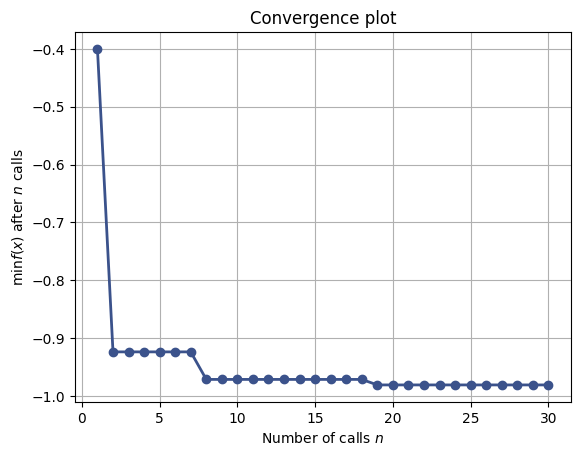

In [8]:
# Visualize the optimization process
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt

plot_convergence(result)
plt.show()